In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from datetime import datetime

In [2]:
def insulin_absorption(I, t, params):
    I_sc1, I_sc2, I_p = I
    k_d, k_a2, k_e, V_I, beta = params
    
    # Delayed insulin and its progression
    dI_sc1_dt = -k_d * I_sc1 + I_p / V_I
    dI_sc2_dt = k_d * I_sc1 - k_a2 * I_sc2
    dI_p_dt = k_a2 * I_sc2 - k_e * I_p
    
    return [dI_sc1_dt, dI_sc2_dt, dI_p_dt]


In [3]:
def glucose_absorption(Q, t, CHO, params):
    Q_sto1, Q_sto2, Q_gut = Q
    k_gri, k_empt, k_abs, f = params
    
    dQ_sto1_dt = -k_gri * Q_sto1 + CHO
    dQ_sto2_dt = k_gri * Q_sto1 - k_empt * Q_sto2
    dQ_gut_dt = k_empt * Q_sto2 - k_abs * Q_gut
    
    Ra = f * k_abs * Q_gut
    return [dQ_sto1_dt, dQ_sto2_dt, dQ_gut_dt], Ra


In [4]:
def glucose_insulin_kinetics(G, t, Ra, I_p, params):
    G_p, X, IG = G
    S_G, p2, SI, Gb, V_G, alpha = params
    
    G_p = min(G_p, 180)  # Clamping to prevent extreme glucose levels
    X = min(X, 180)
    IG = min(IG, 180)

    dG_p_dt = -(S_G + SI * X) * G_p + S_G * Gb + Ra / V_G
    dX_dt = -p2 * (X - SI * (I_p - Gb))
    dIG_dt = -1/alpha * (IG - G_p)
    
    return [dG_p_dt, dX_dt, dIG_dt]


In [5]:
def model_system(state, t, I_input, CHO_input, insulin_params, glucose_params, kinetics_params):
    I_state = state[:3]  # Insulin state variables
    Q_state = state[3:6] # Glucose absorption variables
    G_state = state[6:]  # Glucose-insulin kinetics variables
    
    I_p = I_input(t)
    CHO = CHO_input(t)
    
    dI_state_dt = insulin_absorption(I_state, t, insulin_params)
    dQ_state_dt, Ra = glucose_absorption(Q_state, t, CHO, glucose_params)
    dG_state_dt = glucose_insulin_kinetics(G_state, t, Ra, I_p, kinetics_params)
    
    return np.concatenate([dI_state_dt, dQ_state_dt, dG_state_dt])


In [6]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    basal_data, temp_basal_data, bolus_data, meal_data = [], [], [], []
    
    for basal_event in root.findall(".//basal/event"):
        timestamp = basal_event.get('ts')
        basal_value = float(basal_event.get('value'))
        basal_data.append((timestamp, basal_value))
    
    for temp_basal_event in root.findall(".//temp_basal/event"):
        ts_begin = temp_basal_event.get('ts_begin')
        ts_end = temp_basal_event.get('ts_end')
        temp_basal_value = float(temp_basal_event.get('value'))
        temp_basal_data.append((ts_begin, ts_end, temp_basal_value))
    
    for bolus_event in root.findall(".//bolus/event"):
        ts_begin = bolus_event.get('ts_begin')
        ts_end = bolus_event.get('ts_end')
        bolus_dose = float(bolus_event.get('dose'))
        bolus_data.append((ts_begin, ts_end, bolus_dose))
    
    for meal_event in root.findall(".//meal/event"):
        timestamp = meal_event.get('ts')
        carbs = float(meal_event.get('carbs'))
        meal_data.append((timestamp, carbs))
    
    return basal_data, temp_basal_data, bolus_data, meal_data


In [7]:
def insulin_input(t, basal_data, temp_basal_data, bolus_data):
    insulin = 0
    for (timestamp, basal_value) in basal_data:
        time_in_minutes = time_to_minutes(timestamp, start_time)
        if t >= time_in_minutes:
            insulin += basal_value
    
    for (ts_begin, ts_end, temp_basal_value) in temp_basal_data:
        time_start = time_to_minutes(ts_begin, start_time)
        time_end = time_to_minutes(ts_end, start_time)
        if time_start <= t <= time_end:
            insulin += temp_basal_value
    
    for (ts_begin, ts_end, bolus_dose) in bolus_data:
        time_in_minutes = time_to_minutes(ts_begin, start_time)
        if t >= time_in_minutes:
            insulin += bolus_dose
    
    return insulin


In [8]:
def cho_input(t, meal_data):
    cho = 0
    for (timestamp, carbs) in meal_data:
        time_in_minutes = time_to_minutes(timestamp, start_time)
        if t >= time_in_minutes:
            cho += carbs
    return cho


In [9]:
def time_to_minutes(timestamp, start_time):
    fmt = '%d-%m-%Y %H:%M:%S'
    ts = datetime.strptime(timestamp, fmt)
    diff = ts - start_time
    return diff.total_seconds() // 60

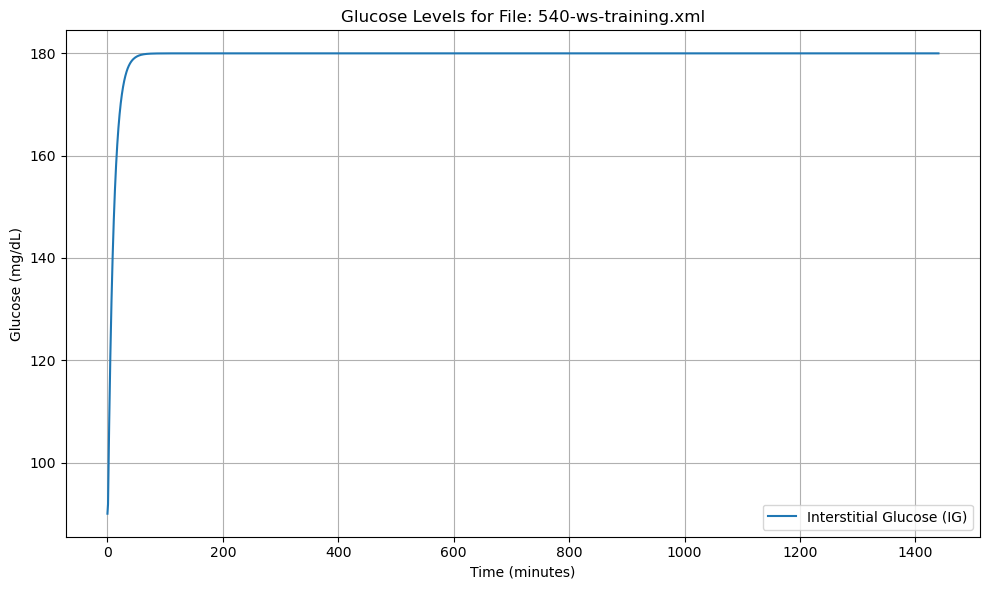

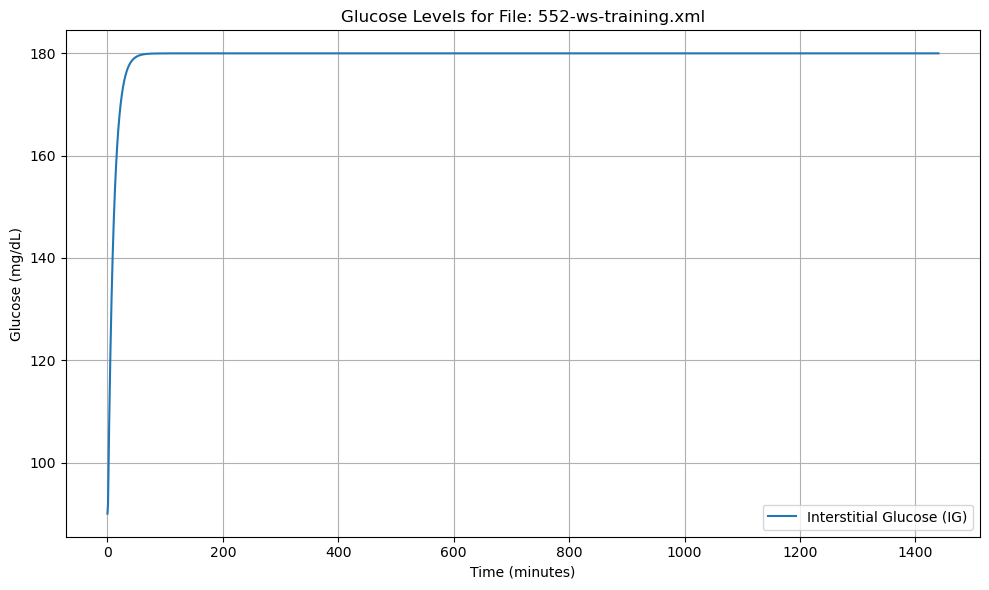

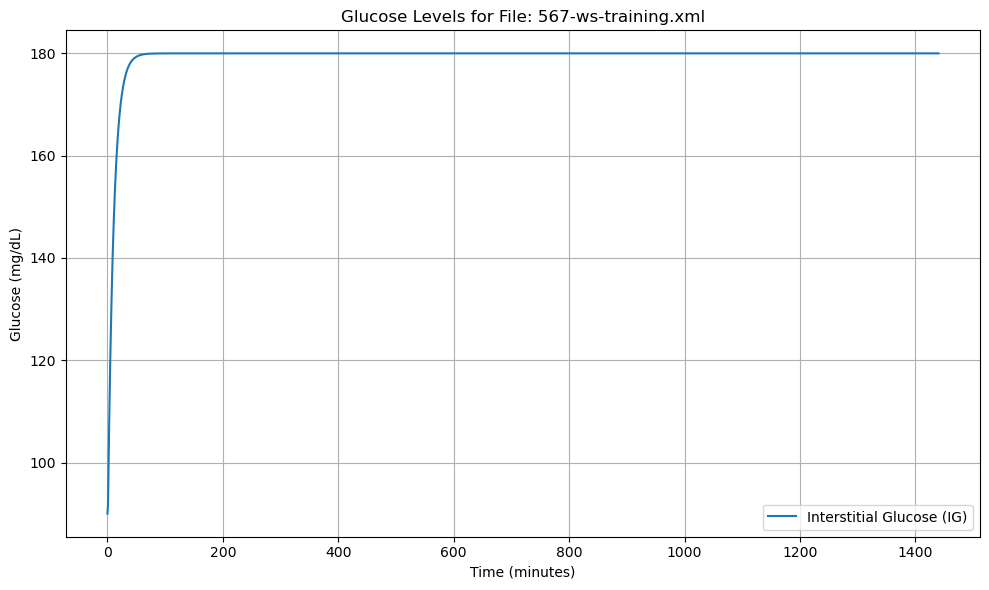

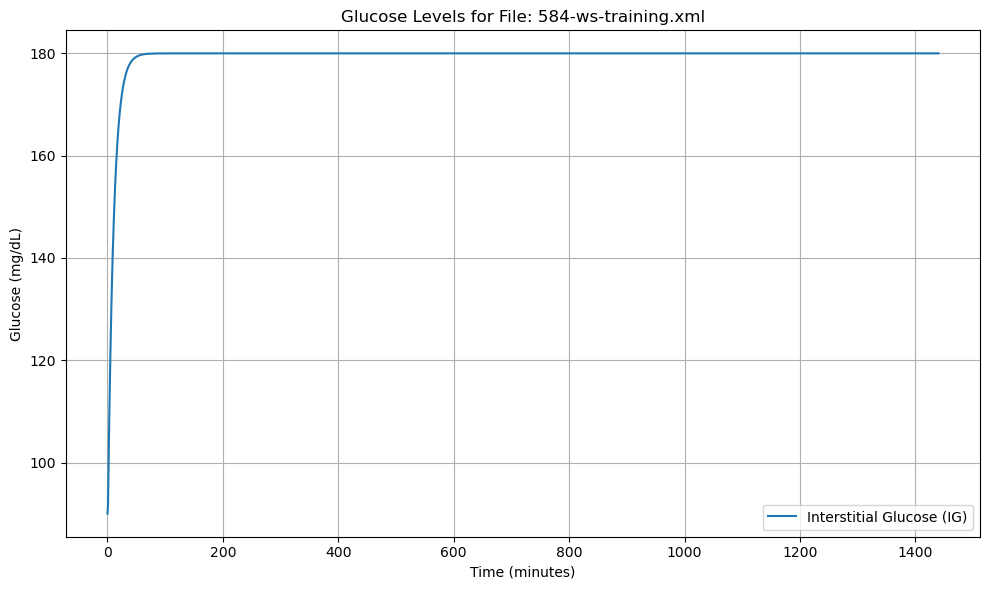

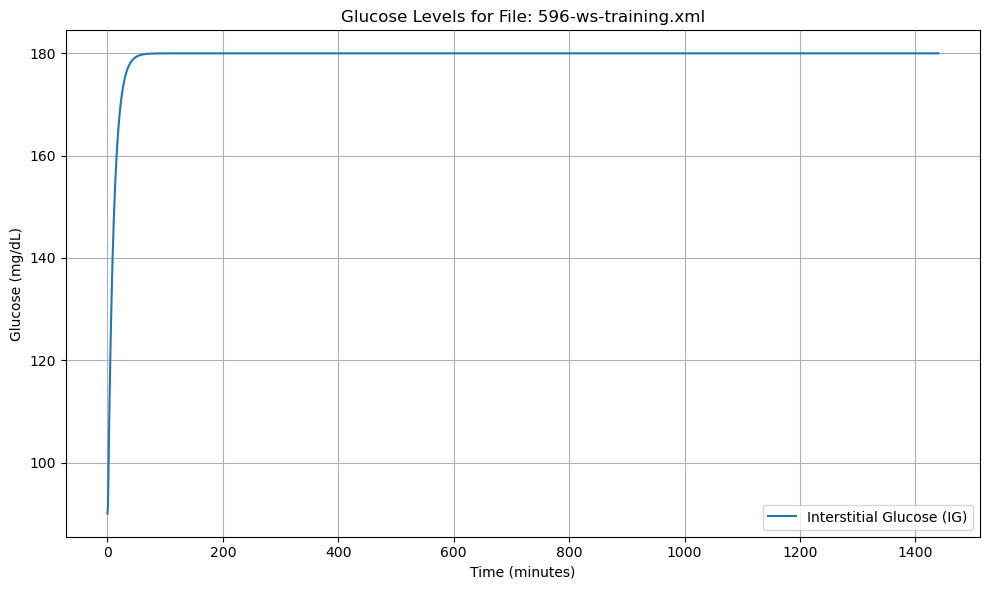

In [14]:
import os


xml_dir = 'E:/SEM8/Datasets/Ohio T1DM/OhioT1DM/2020/train'

# Get all .xml file paths in the directory
xml_files = [os.path.join(xml_dir, f) for f in os.listdir(xml_dir) if f.endswith('.xml')]

# Parameter adjustments to reflect realistic glucose dynamics
insulin_params = [0.02, 0.04, 0.1, 0.12, 6]  # Reduced volume and absorption rate
glucose_params = [0.05, 0.1, 0.04, 0.85]  # Adjust glucose absorption slightly
kinetics_params = [0.02, 0.08, 0.4, 85, 1.3, 10]  # Modify insulin sensitivity

# Loop through each XML file
for xml_file in xml_files:
    # Parse the XML file
    basal_data, temp_basal_data, bolus_data, meal_data = parse_xml(xml_file)

    # Get start time for simulation
    start_time = datetime.strptime(basal_data[0][0], '%d-%m-%Y %H:%M:%S')

    # Define time vector
    t_eval = np.linspace(0, 1440, 1440)  # 1440 minutes (1 day)

    # Initial conditions
    initial_state = [0, 0, 0, 0, 0, 0, 90, 0, 90]  # Initial insulin/glucose states

    # Define inputs using parsed data
    I_input = lambda t: insulin_input(t, basal_data, temp_basal_data, bolus_data)
    CHO_input = lambda t: cho_input(t, meal_data)

    # Solve ODEs using solve_ivp for stiff problems
    def model_system_wrapper(t, state, I_input, CHO_input, insulin_params, glucose_params, kinetics_params):
        return model_system(state, t, I_input, CHO_input, insulin_params, glucose_params, kinetics_params)

    result = solve_ivp(model_system_wrapper, [0, 1440], initial_state, method='LSODA',
                       args=(I_input, CHO_input, insulin_params, glucose_params, kinetics_params),
                       t_eval=t_eval)

    # Access the results
    t = result.t
    glucose_levels = result.y[8]

    # Plot the glucose levels over time
    plt.figure(figsize=(10, 6))
    plt.plot(t, glucose_levels, label="Interstitial Glucose (IG)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose (mg/dL)')
    plt.title(f"Glucose Levels for File: {os.path.basename(xml_file)}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()